# MCMC Hammer
### Sophia Bender
### 5/18/2025

[1]  Emcee implements Goodman & Weare's affine-invariant Markov Chain Monte Carlo (MCMC) Ensemble sampler into Python, in order to perform Bayesian parameter estimation. This means that, instead of simply finding the 'best fit' parameters, emcee helps estimate the probability distributions of model parameters based on prior beliefs. These probability distributions can then be refined using observed data. Emcee is great at handling uncertainty in a principled, probabilistic way, and it can explore complex, high-dimensional parameter spaces efficiently. 

[2] I selected emcee because it is one of the most downloaded codes used in papers, and it appears to be extremely useful for dealing with uncertainties and unknown parameters, which there are a lot of in physics. Since I am interested in particle physics especially, I think understanding how emcee works would be helpful to me in the future.

[3] Emcee was first developed in 2010 by Dan Foreman-Mackey, and other contributors. The current version of emcee is 3.1.6, which was released on April 19, 2024. It has many predecessors and successors or alternatives that inspired, extends, or complements it. Before emcee came `PyMC`, which was a python package that used MCMC in a heavier, more general-purpose way. Later versions of `PyMC` that followed the creation of emcee are more advanced, and more automatic than emcee. `CosmoMC` was another MCMC-based python package that came before emcee, but was specialized to cosmology. Some more packages that came after emcee are: `Pystan`, which uses Hamiltonian Monte Carlo for Bayesian inference, `NumPyro`, which supports modern inference methods, and `Dynesty`, which was developed by the same author as emcee and is better for computing Bayesian evidence. 

[4] Emcee is still currently being maintained by its original authors. The GitHub repository lists 67 contributors, and it seems to garner much community engagement. 

[5/6]  Emcee was incredibly easy to install as a python library. As it is a third-party library, it required the `!pip install` command, as well as the import command. I used the package to fit an artificial model to a data, which required quite a bit of set up in order to get to the point of using emcee. I would say the usage was not that simple.

In [44]:
!pip install emcee

In [5]:
import emcee 

[7] You can inspect the source code through the GitHub repository, by using Python's inspect module, or going into the site-packages folder. 

In [6]:
import inspect 
print(inspect.getfile(emcee)) 

\\?\C:\Users\Sophi\AppData\Roaming\jupyterlab-desktop\envs\env_1\Lib\site-packages\emcee\__init__.py


[8] `Gammapy` is an open-source Python package for gamma-ray astronomy that employs emcee for MCMC sampling in spectral and spacial model fitting. `Bilby` is a Bayesian inference library designed for gravitational-wave astronomy, and it provides a flexible interface to various samplers, including emcee. 

[9] Emcee can be used on standard python script for large experiments or when integrated into data piplelines, and Jupyter Notebooks for research and education. 

[10] Here is an example where we fit a model to data with a generative probabilistic model, a maximum likelihood estimation, and a marginalization and uncertainty estimation using emcee. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1224)

# Choose the "true" parameters.
m_true = -1.20
b_true = 5.13
f_true = 0.2006

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

x0 = np.linspace(0, 10, 500)

A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)
    
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

samples = sampler.get_chain()

100%|██████████| 5000/5000 [00:05<00:00, 914.81it/s]


[11] Matplotlib must be employed to generate figures, as emcee does not produce figures itself. 

[12] Here is a figure of a diagnostic plot that projects the results into the space of the observed data. I chose 200 samples from the chain and plotted them on top of the data points. 

(10432, 3)


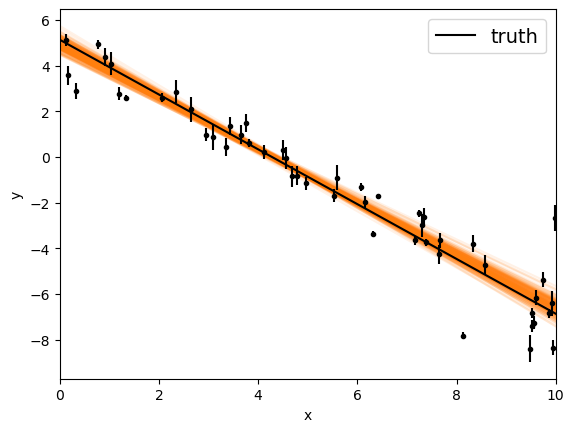

In [10]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

inds = np.random.randint(len(flat_samples), size=200)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

[13] Emcee is purely python, and does not need accompanying code. 

[14] The core input to emcee is a log-probability function that takes theta, which is a vector of model parameters, and returns a single scalar value of the log of the posterior probability. Aside from the core input, you will also need a NumPy array of shape, number of walkers (independent chains), and number of parameters (dimensions of theta). You must come up with and handle the data on your own, as emcee does not take the data directly. The data can be synthetically generated before calling the sampler. 

[15] The primary output of emcee is the chain of samples from the posterior distribution of your model parameters. You can also get a flattened chain, which is a cleaned, reshaped posterior for plots and analysis, and you can get a log-probability for each sample. 

[16] Emcee includes a many unit tests to ensure the correctness and stability of its core functionalities. These tests are part of the package's source code, and can be executed to verify that the installation and internal operations are functioning as expected. If the test fails after a code change, it indicates a regression. Emcee doesn't have a dedicated benchmarking suite. 

[17] To ensure confidence in the result that emcee provides, you can run an internal unit test using `emcee.test()` to confirm the code is behaving as expected. You can manually check regression using Python's `pytest` feature. 

[18] Emcee depends on NumPy. Other libraries that are not for basic usage but can be used in addition to emcee are `pytest`, `SciPy`, `matplotlib`, and `corner`. I used the `!pip show emcee` command to determine the required library. A section on the emcee Github called `pyproject.toml` also provides a list of dependencies. 

In [2]:
!pip show emcee 

Name: emcee
Version: 3.1.6
Summary: The Python ensemble sampling toolkit for MCMC
Home-page: https://emcee.readthedocs.io
Author: Daniel Foreman-Mackey
Author-email: foreman.mackey@gmail.com
License: MIT
Location: C:\Users\Sophi\AppData\Roaming\jupyterlab-desktop\envs\env_1\Lib\site-packages
Requires: numpy
Required-by: 


[19] The emcee Github repository directs you to the website https://emcee.readthedocs.io This website provided all the documentation, as well as many examples and explanations for how the code can be used. I found these to be sufficient, and used one of the examples for my own code for this project, with my own randomly generated data. The paper by Dan Foreman-Mackey also provides details about the emcee algorithm and its usage. 

[20] They request that people cite the paper by Foreman-Mackey, Hogg, Lang & Goodman (2012) if the code is used in research. 

[21] 
- Preferred citation: https://arxiv.org/abs/1202.3665
- emcee GitHub Repository: https://github.com/dfm/emcee
- emcee GitHub Read the Docs: https://emcee.readthedocs.io/en/stable/
- David MacKay's Information Theory, Inference, and Learning Algorithms: https://www.inference.org.uk/itprnn/book.pdf

[22] 
Using ADS there are 10665 citations to "emcee: The MCMC Hammer", including: 
- Transit timing variations of the sub-Saturn exoplanet HAT-P-12b: https://ui.adsabs.harvard.edu/#abs/2025NewA..11902390P/abstract
- Studying orbital period variations of XY Leo through updated eclipse times and multi-model analysis: https://ui.adsabs.harvard.edu/#abs/2025NewA..11802374N/abstract

[23] I did not have to learn new python methods to use this package. Generating artificial data and running fit models were all things we've done in class. 

[24] I have not had prior experience with emcee. I did collaborate with others, but we all used separate code, examples, and data. 